In the code cell below I import the python libraries that are used in this project. The dataset is loaded onto a pandas dataframe and df.head() is used to verify import path.

In [1]:
# Caffeine intake health prediction

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('../data/synthetic_coffee_health_10000.csv')

display(df.head())
display(df.info())
display(df.describe())

,ID,Age,Gender,Country,Coffee_Intake,Caffeine_mg,Sleep_Hours,Sleep_Quality,BMI,Heart_Rate,Stress_Level,Physical_Activity_Hours,Health_Issues,Occupation,Smoking,Alcohol_Consumption
0,1,40,Male,Germany,3.5,328.1,7.5,Good,24.9,78,Low,14.5,NaN,Other,0,0
1,2,33,Male,Germany,1.0,94.1,6.2,Good,20.0,67,Low,11.0,NaN,Service,0,0
2,3,42,Male,Brazil,5.3,503.7,5.9,Fair,22.7,59,Medium,11.2,Mild,Office,0,0
3,4,53,Male,Germany,2.6,249.2,7.3,Good,24.7,71,Low,6.6,Mild,Other,0,0
4,5,32,Female,Spain,3.1,298.0,5.3,Fair,24.1,76,Medium,8.5,Mild,Student,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       10000 non-null  int64  
 1   Age                      10000 non-null  int64  
 2   Gender                   10000 non-null  object 
 3   Country                  10000 non-null  object 
 4   Coffee_Intake            10000 non-null  float64
 5   Caffeine_mg              10000 non-null  float64
 6   Sleep_Hours              10000 non-null  float64
 7   Sleep_Quality            10000 non-null  object 
 8   BMI                      10000 non-null  float64
 9   Heart_Rate               10000 non-null  int64  
 10  Stress_Level             10000 non-null  object 
 11  Physical_Activity_Hours  10000 non-null  float64
 12  Health_Issues            4059 non-null   object 
 13  Occupation               10000 non-null  object 
 14  Smoking                

None

,ID,Age,Coffee_Intake,Caffeine_mg,Sleep_Hours,BMI,Heart_Rate,Physical_Activity_Hours,Smoking,Alcohol_Consumption
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.00000,10000.000000
mean,5000.50000,34.949100,2.509230,238.411010,6.636220,23.986860,70.617800,7.48704,0.20040,0.300700
std,2886.89568,11.160939,1.450248,137.748815,1.222055,3.906411,9.822951,4.31518,0.40032,0.458585
min,1.00000,18.000000,0.000000,0.000000,3.000000,15.000000,50.000000,0.00000,0.00000,0.000000
25%,2500.75000,26.000000,1.500000,138.750000,5.800000,21.300000,64.000000,3.70000,0.00000,0.000000
50%,5000.50000,34.000000,2.500000,235.400000,6.600000,24.000000,71.000000,7.50000,0.00000,0.000000
75%,7500.25000,43.000000,3.500000,332.025000,7.500000,26.600000,77.000000,11.20000,0.00000,1.000000
max,10000.00000,80.000000,8.200000,780.300000,10.000000,38.200000,109.000000,15.00000,1.00000,1.000000


The next step is to check if we have any missing values in our dataset by running isnull().sum(). By doing this we can see that the chosen dataset is clean of missing values except for health issues where 59.41% of people are free from health issues. One thing to note with this is that we cant be sure if all 5941 are healthy or if some of these are actual missing values. As the column Health_Issues is a categorical variable None, Mild, Moderate, Severe I am replacing the NaN's with string None to match the description of the dataset on Kaggle and to make it more consistent for modelling and analysis. I also dropped the column Coffee_Intake as it just contains how many cups of coffee individuals have but since we also have Caffeine_mg it is just redundant. Also it's not an accurate way to measure caffeine intake as I'm not sure if things like energy drinks are counted in it. Also check rows and number of columns

In [2]:
df_missing = pd.DataFrame(df)

df_missing = df_missing.drop(columns=['Coffee_Intake'])

display(df_missing.isnull().sum())

df_missing['Health_Issues'] = df_missing['Health_Issues'].fillna('None')
display(df_missing['Health_Issues'])

df_missing.shape

ID                            0
Age                           0
Gender                        0
Country                       0
Caffeine_mg                   0
Sleep_Hours                   0
Sleep_Quality                 0
BMI                           0
Heart_Rate                    0
Stress_Level                  0
Physical_Activity_Hours       0
Health_Issues              5941
Occupation                    0
Smoking                       0
Alcohol_Consumption           0
dtype: int64

0           None
1           None
2           Mild
3           Mild
4           Mild
          ...   
9995    Moderate
9996        Mild
9997        None
9998        None
9999        None
Name: Health_Issues, Length: 10000, dtype: object

(10000, 15)

The next step I took was to look at my data and how things are distributed and balanced. One thing I noticed right away was that the category for severe health problems only contain 17 individuals out of 10 000 (0.0017%) which is extremely rare so to make predictions with a model "better" I combined Moderate and Severe into a new column called ModerateAndSevere.

In [3]:
for col in ['Health_Issues', 'Gender', 'Stress_Level', 'Smoking', 'Alcohol_Consumption']:
    print(df_missing[col].value_counts())
    print()

df_colcombined = df_missing.copy()
df_colcombined['Health_Issues'] = df_colcombined['Health_Issues'].replace({'Moderate': 'ModerateAndSevere', 'Severe': 'ModerateAndSevere'})

df_colcombined['Health_Issues'].value_counts()


Health_Issues
None        5941
Mild        3579
Moderate     463
Severe        17
Name: count, dtype: int64

Gender
Female    5001
Male      4773
Other      226
Name: count, dtype: int64

Stress_Level
Low       6989
Medium    2050
High       961
Name: count, dtype: int64

Smoking
0    7996
1    2004
Name: count, dtype: int64

Alcohol_Consumption
0    6993
1    3007
Name: count, dtype: int64



Health_Issues
None                 5941
Mild                 3579
ModerateAndSevere     480
Name: count, dtype: int64

After inspecting the general distribution of some of the attributes in my dataset I also chose to plot the data to take a closer look. First I selected all columns containing numerical data for histograms. As we can see in the histograms we have some strange patterns or phenomena in Age, Caffeine_mg, BMI and Heart_Rate. The biggest Age group by far is 18 which contains 935 entries while all other ages contain around 100-400 entries. The reason for this is unknown but one explanation could be that the creator/s of the dataset used 18 as the fallback age if it was unknown/nAn. It could also be that the dataset focused on young adults (18 year olds) and thus skewed the distribution of age. Since age is skewed interpretations regarding age should be proceeded with caution.

The same observation can be made for Caffeine_mg where the first bar in the histogram is the second biggest. But the explanation for this can be found in that 528 people drink no caffeine which seems logical. If the non-caffeine drinkers were to be removed from the histogram no weird distribution would be observed.

For BMI we also see this with 120 people being on BMI 15.0 which is considered severly underweight and super unhealthy. This does not seem to be a normal and natural distribution as it also must be some kind of fallback default value for when BMI is not known. Since the dataset is synthetically created from real-world patterns there might have been some error when generating BMI so values lower than 15 might be sat as 15, which is the minimum here.

The Heart Rate attribute has a little spike at 50 bpm with 214 people, which is a little strange as the rest follows a normal distribution. The reason for this could be as previously stated, that the default method for missing values is to impute the lowest value. It could also be that people with heart rates lower than 50, like athletes for example that can have resting heart rates around 40 get heart rate 50 here because it's the lowest value. It could also be that when the data was generated there was a limit at 50 so all values under it were put there.

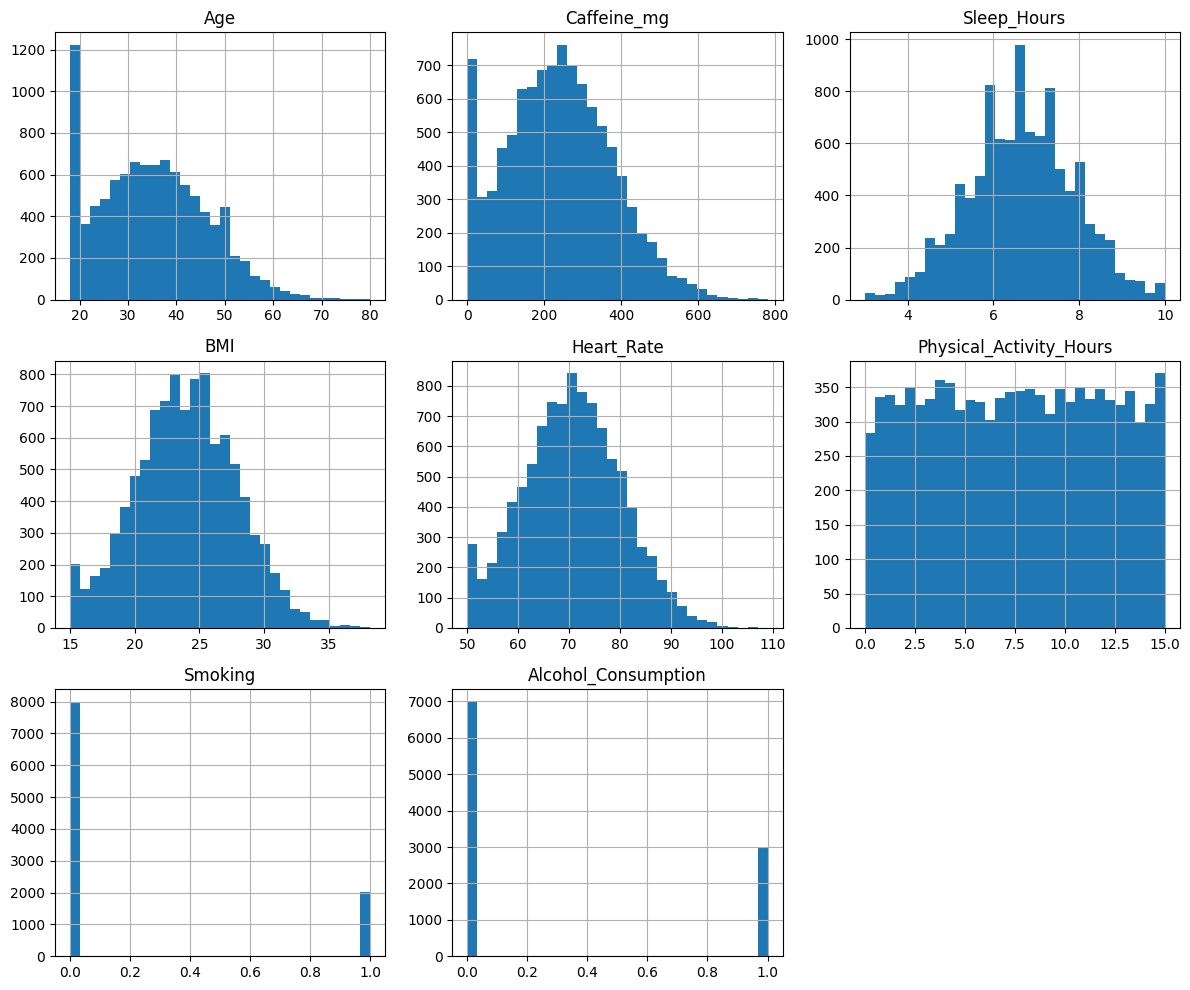

Age
18    935
19    133
20    154
21    171
22    194
23    221
24    229
25    256
26    225
27    291
Name: count, dtype: int64
528
BMI
15.0    120
15.1      9
15.2      6
15.3     11
15.4     16
15.5      8
15.6     20
15.7     13
15.8     11
15.9     14
Name: count, dtype: int64
Heart_Rate
50    214
51     62
52     87
53     74
54     96
55    118
56    161
57    156
58    188
59    227
Name: count, dtype: int64


In [4]:
int_cols = df_colcombined.select_dtypes(include=['int64', 'float64']).columns.drop('ID')
int_cols

df_int = df_colcombined[int_cols]
df_int.hist(figsize=(12, 10), bins=30)
plt.tight_layout()
plt.show()

print(df_int['Age'].value_counts().sort_index().head(10))

print(df_int[df_int["Caffeine_mg"] == 0].shape[0])

print(df_int['BMI'].value_counts().sort_index().head(10))

print(df_int['Heart_Rate'].value_counts().sort_index().head(10))



Boxplots

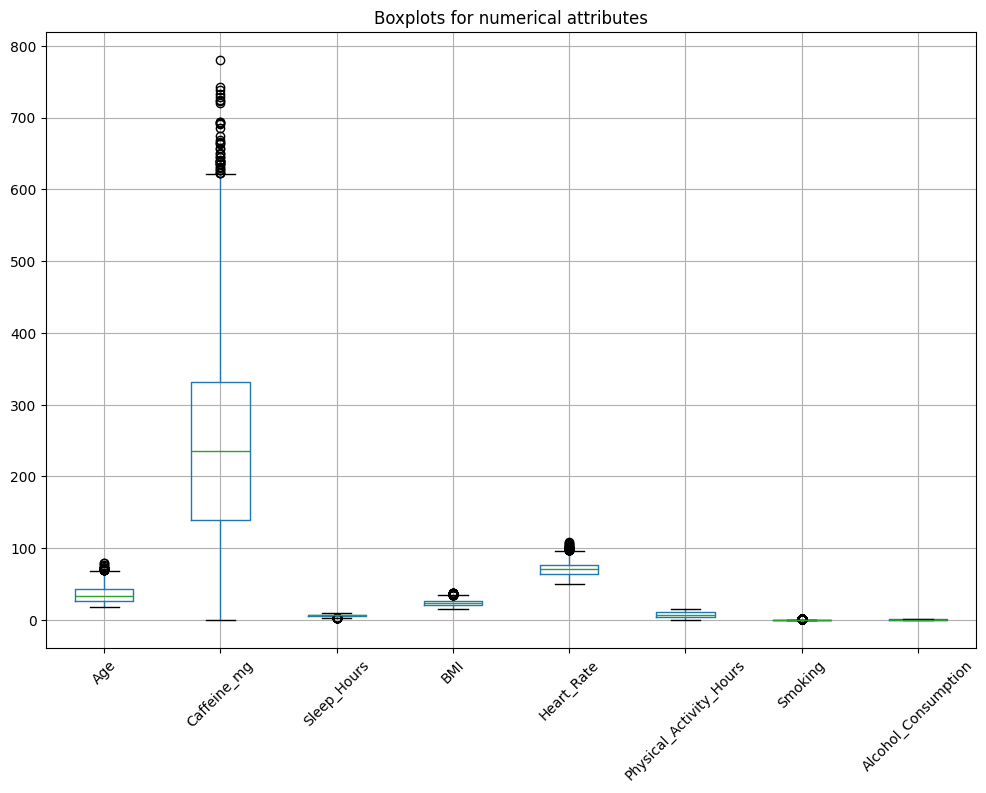

In [5]:
plt.figure(figsize=(12, 8))
df_int.boxplot(rot=45)
plt.title('Boxplots for numerical attributes')
plt.show()

After plotting the numerical attributes it was time to plot the categorical and object variables. The chosen method was use bar plots to see the general distribution. As we can see the distribution is very even and what we would have expected. Since the dataset is synthetically generated (representing real world patterns) some attributes are very even which will help us get less bias and easier learning for our model. If this data was gathered we wouldn't have such even distribution for e.g. occupation or maybe country but other than that the distributions are realistic.

ID                           int64
Age                          int64
Gender                      object
Country                     object
Caffeine_mg                float64
Sleep_Hours                float64
Sleep_Quality               object
BMI                        float64
Heart_Rate                   int64
Stress_Level                object
Physical_Activity_Hours    float64
Health_Issues               object
Occupation                  object
Smoking                      int64
Alcohol_Consumption          int64
dtype: object
Plotting: Country


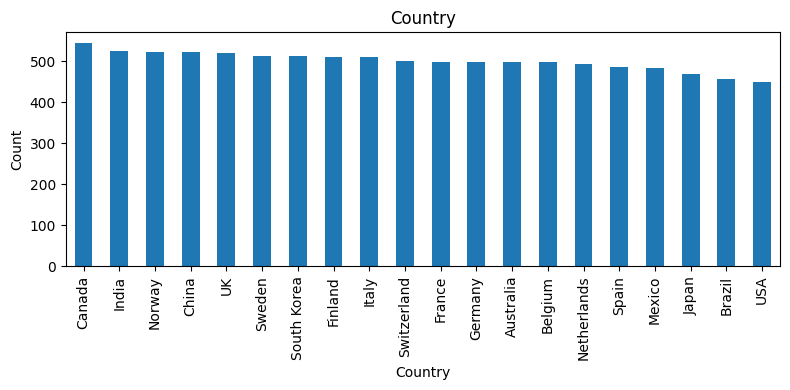

Plotting: Gender


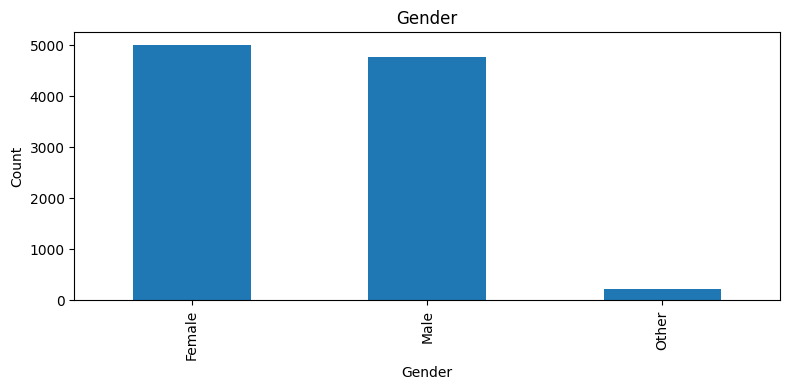

Plotting: Occupation


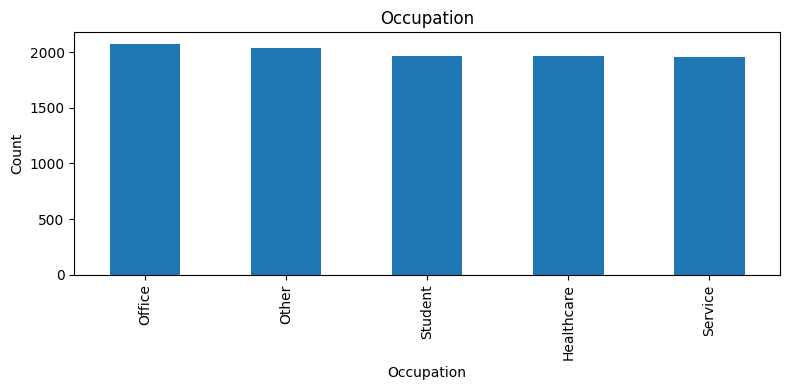

Plotting: Sleep_Quality


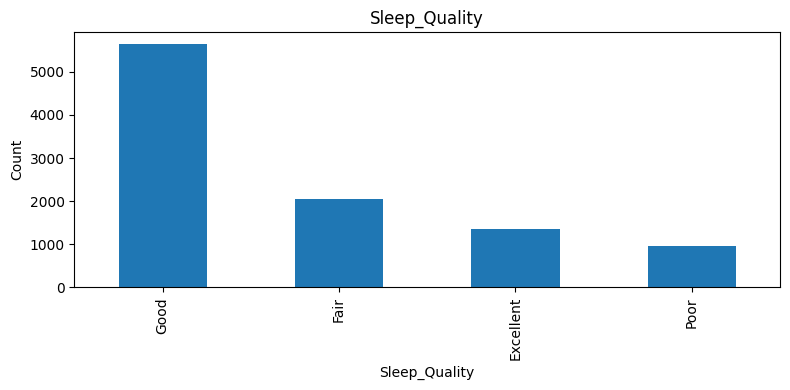

Plotting: Stress_Level


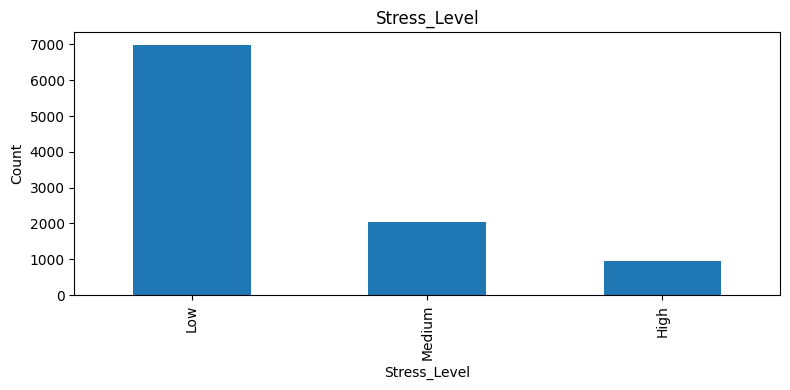

In [6]:
print(df_colcombined.dtypes)

def plot_categorical_distribution(df_colcombined, exclude=None, figsize=(8, 4)):
    
    exclude = set(exclude or [])

    cat_cols = (
        df_colcombined.select_dtypes(include=["object", "category"]).columns.difference(exclude)
    )

    for col in cat_cols:
        print("Plotting:", col)
        plt.figure(figsize=(8, 4))
        df_colcombined[col].value_counts(dropna=False).plot(kind='bar')
        plt.title(col)
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

plot_categorical_distribution(df_colcombined, exclude=['Health_Issues'], figsize=(8, 4))

Since the dataset contains a lot of categorical and object columns which are needed for the model to make predictions we need to convert/encode these into numerical values for the model. I also chose to drop the column 'ID' because that isn't needed for the model. The columns we need to encode are; Gender, Country, Sleep_Quality, Stress_Level, and Occupation. I used OneHotEncoder for Gender, Country, and Occupation whilst I used OrdinalEncoder for Sleep_Quality and Stress_Level.

Split into nominal, ordinal, and numeric cols.

Standard Scaler on numerical cols.

In [7]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

categories = df_colcombined['Sleep_Quality'].unique()
print(categories)

df_colcombined = df_colcombined.drop(columns=['ID'])

nominal_cols = ['Gender', 'Country', 'Occupation']
ordinal_cols = ['Stress_Level', 'Sleep_Quality']
numerical_cols = ['Age', 'Caffeine_mg', 'Sleep_Hours', 'BMI', 'Heart_Rate', 'Physical_Activity_Hours', 'Smoking', 'Alcohol_Consumption']

ordinal_categories = [
    ['Low', 'Medium', 'High'],  # Stress_Level
    ['Poor', 'Fair', 'Good', 'Excellent'],  # Sleep_Quality
]

preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', OneHotEncoder(handle_unknown='ignore'), nominal_cols),
        ('ordinal', OrdinalEncoder(categories=ordinal_categories), ordinal_cols),
        ('numerical', StandardScaler(), numerical_cols)
    ])





['Good' 'Fair' 'Excellent' 'Poor']


This is the first logistic regression model using all features in the dataset to predict health issues.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = df_colcombined.drop(columns=['Health_Issues'])
y = df_colcombined['Health_Issues']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42
)

regression_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(multi_class='multinomial', max_iter=1000, solver='lbfgs'))
])

regression_model.fit(X_train, y_train)

y_pred = regression_model.predict(X_test)
print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

             Mild       0.87      0.82      0.85      1060
ModerateAndSevere       0.64      0.43      0.52       130
             None       0.92      0.97      0.94      1810

         accuracy                           0.89      3000
        macro avg       0.81      0.74      0.77      3000
     weighted avg       0.89      0.89      0.89      3000



c:\Users\emilg\OneDrive\Dokument\GitHub\Caffeine-health-problems-prediction\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Since my first idea with this project was to study if caffeine intake can be used as a predictor for health issues I ran a logistic regression model on this which unsurprisingly can't be used for predictions.

In [9]:
X_caffeine = df_colcombined[['Caffeine_mg']]
y_ = df_colcombined['Health_Issues']

X_train_caf, X_test_caf, y_train_caf, y_test_caf = train_test_split(
    X_caffeine,
    y,
    test_size=0.3,
    random_state=42
)

caffeine_regression_model = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('classifier', LogisticRegression(multi_class='multinomial', max_iter=1000))
])

caffeine_regression_model.fit(X_train_caf, y_train_caf)
y_pred = caffeine_regression_model.predict(X_test_caf)
print(classification_report(y_test_caf, y_pred))

                   precision    recall  f1-score   support

             Mild       0.49      0.03      0.05      1060
ModerateAndSevere       0.00      0.00      0.00       130
             None       0.61      0.99      0.75      1810

         accuracy                           0.60      3000
        macro avg       0.37      0.34      0.27      3000
     weighted avg       0.54      0.60      0.47      3000



c:\Users\emilg\OneDrive\Dokument\GitHub\Caffeine-health-problems-prediction\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\emilg\OneDrive\Dokument\GitHub\Caffeine-health-problems-prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\emilg\OneDrive\Dokument\GitHub\Caffeine-health-problems-prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parame

The model including all columns to predict Health issues showed that decently accurate predictions can be made already. I also tried to predict using only caffeine as the predictor but that is not a good predictor. So to explore what features are important predictors in the model my first thought was to make a separate linear regression model for each of them but that approach has a few flaws. The first is that it doesn't take relationships/behaviour/correlation between features into account. The model is also forced to use features that might be weak and noise might affect the model. I could use logistic regression coefficients but since I have some encoded columns I decided to skip this.

So to investigate what features have the biggest impact/importance for predictions im using the permutation feature importance for the model. The permutation feature shows the features and the contribution of them to the model's statistical performance. In our case we can observe that Stress_Level is by far the biggest contributor for my model, followed by Age, BMI and Sleep_Quality. One observation that was unexpected was that the smoking category didn't have a bigger impact for the model as the value is negative. One explanation for this might be that the split between non-smokers and smokers is about 80/20 so the amount of smokers might be too small to have an impact on the model. Another reason could be as discussed during my supervision, that confounding variables may affect both smoking and alcohol consumption and it's impact on predictions.

Since this is just the results of a logistic regression model it only looks at linear relationships. It skips and doesn't tell us anything about nonlinear relationships, confounding variables and other interactions. The next step is to see what result a random forest model gives us.

In [10]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    regression_model, X_test, y_test,
    n_repeats=10,
    random_state=42
)

feature_names = X_test.columns

importances = pd.Series(result.importances_mean, index=feature_names).sort_values(ascending=False)

print(importances)

Stress_Level               0.322233
Age                        0.075600
BMI                        0.033667
Sleep_Quality              0.019667
Sleep_Hours                0.000700
Physical_Activity_Hours    0.000533
Occupation                 0.000433
Gender                     0.000033
Heart_Rate                 0.000033
Alcohol_Consumption       -0.000100
Smoking                   -0.000600
Caffeine_mg               -0.000667
Country                   -0.001367
dtype: float64


The next step is to train a Random Forest model to analyze non linear relationships and to once again see feature importance.

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
import numpy as np

# The train/test split
X = df_colcombined.drop(columns=['Health_Issues'])
y = df_colcombined['Health_Issues']

# y_shuffled = np.random.permutation(y)


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42
)

# Our model
random_forest_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=300,
        min_samples_split=2,
        min_samples_leaf=1,
        max_depth=8,
        random_state=42,
        n_jobs=1
    ))
])

# Train model
random_forest_model.fit(X_train, y_train)

y_pred = random_forest_model.predict(X_test)

print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

             Mild       0.99      1.00      0.99      1060
ModerateAndSevere       1.00      0.91      0.95       130
             None       1.00      1.00      1.00      1810

         accuracy                           0.99      3000
        macro avg       1.00      0.97      0.98      3000
     weighted avg       0.99      0.99      0.99      3000



After seeing the unusually high accuracy of the model I looked up and discovered that my dataset artificially creates Health_Issues based on Age, BMI and Sleep which my model is just discovering. My model isn't actually predicting anything but instead just rediscovering how the attributes were generated by the creator of the dataset. So moving forward I will be changing my dataset to the "Behavioral Risk Factor Surveillance System by the CDC - Center for Desease Control and Prevention which surveyed around 400 000 individuals in the U.S.

The research question still remains. Can we predict Health issues in individuals using different physiological and lifestyle factors? To answer this question im swapping out the previous dataset that was made synthetically to simulate real world patterns. The problem/s with that dataset was that the features/columns I was trying to predict were already derived from existing physiological features so there was no predicting taking place but instead the algorithms uncovered how these features/labels were generated by the creator of the dataset. 

So moving forward I have found a new dataset with similar features, although this one is a bit more focused on different health conditions. Im changing the research question a little bit to better suit this dataset so instead of trying to predict Health issues in general I have chosen to predict diabetes as a multi-class classification; 0 = no diabetes, 1 = prediabetes, 2 diabetes. So the research question will be "Can diabetes be predicted using features regarding health and lifestyle?

I started out by inspecting the dataset as usual. I also checked the distribution for the class im trying to predict and it is imbalanced as expected with a majority being non-diabetic, 35 346 being diabetic, and only 4631 being prediabetic. This distribution is gonna make predicting prediabetic a bit difficult but the distribution is also realistic. The distribution is 82.5% non-diabetic, 1.8% prediabetic, and 13.6% diabetic.


In [12]:
df = pd.read_csv('../data/diabetes_012_health_indicators_BRFSS2015.csv')

display(df.head())
display(df.info())
display(df.describe())

print(df['Diabetes_012'].value_counts())

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

None

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.296921,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,0.811420,0.056197,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.698160,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,0.391175,0.230302,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,2.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


Diabetes_012
0.0    213703
2.0     35346
1.0      4631
Name: count, dtype: int64


The dataset has already had some formatting and grouping done since the data is taken straight from the CDC survey. There has for instance been grouping of; 
High Bloodpressure (0,1), 
High Cholesterol (0,1), 
CholCheck (colesterol check in the last 5 years 0,1), 
Smoker (at least 100 cigarettes in your life 0,1), 
Stroke (0,1), 
HeartDiseaseorAttack (0,1), 
PhysActivity (in the past 30 days 0,1), 
Fruits (1 or more per day 0,1), 
Veggies (1 or more per day 0,1), 
HvyAlcoholConsump (Men more than 14 drinks a week, women more than 7; 0,1), 
AnyHealthcare (Any kind of health care coverage like health insurance, prepaid plans 0,1)
NoDocbcCost (Time in the past 12 months you needed to see a doctor but could not because of cost 0,1)
GenHlth (1-5, 1 = excellent, 2 = very good, 3 = good, 4 = fair, 5 = poor)
MentHlth (for how many days during the past 30 days was your mental health not good? scale 1-30 days)
PhysHlth (for how many days during the past 30 days was your physical health not good? scale 1-30 days)
DiffWalk (difficulty walking or climbing stairs? 0,1)
Sex (0 = female, 1 = male)
Age (13-level age category 1 = 18-24, 9 = 60-64, 13 = 80 or older)
Education (1-6. 1 = never attended school/only kindergarten, 2 = grades 1-8, 3 = 9-11, 4 = 12 or High school grad, 5 = College 1-3 year, 6 = College 4 or more years)
Income (scale 1-8. 1 = less than $10 000, 5 = less than $35 000, 8 = $75 000 or more)


After the initial inspection I checked for any missing values and duplicate rows. After checking there are about 35 000 duplicate rows but this isn't something to worry about since the data is collected from a survey where a lot of the answers are either binary (0,1) or on a scale 1-13 or 1-8.

In [13]:
df_missing = pd.DataFrame(df)

display(df_missing.isnull().sum())

duplicate_rows = df[df.duplicated(keep=False)]
print({duplicate_rows.shape[0]})

duplicate_rows.head(10)


Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

{35086}


,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
5,0.0,1.0,1.0,1.0,25.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,1.0,10.0,6.0,8.0
25,0.0,0.0,0.0,1.0,32.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,5.0,6.0,8.0
29,0.0,0.0,1.0,1.0,31.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
44,0.0,0.0,1.0,1.0,31.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0
52,2.0,1.0,1.0,1.0,27.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,0.0,30.0,1.0,0.0,10.0,4.0,5.0
53,0.0,0.0,0.0,1.0,31.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,10.0,5.0,6.0
57,0.0,0.0,1.0,1.0,24.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,10.0,6.0,8.0
70,0.0,1.0,1.0,1.0,27.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,12.0,5.0,5.0
80,0.0,1.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,7.0,6.0,8.0
113,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,8.0,6.0,8.0


The next step is to start plotting the data to get a view on it's distribution

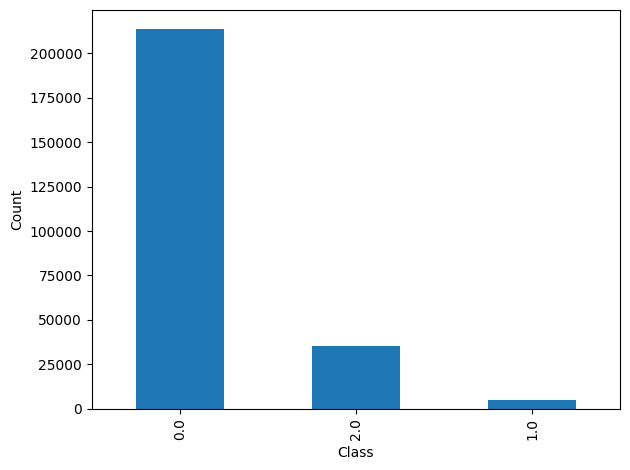

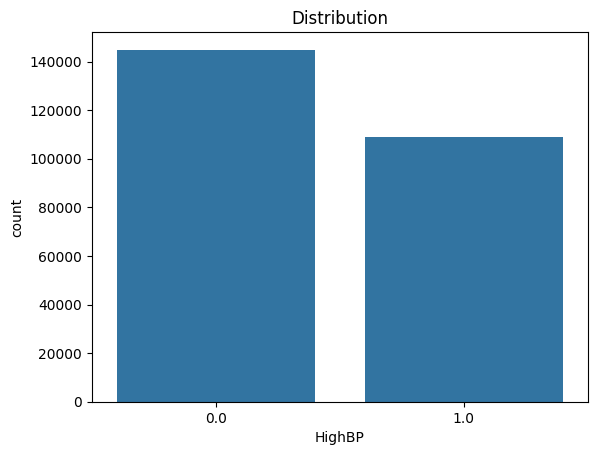

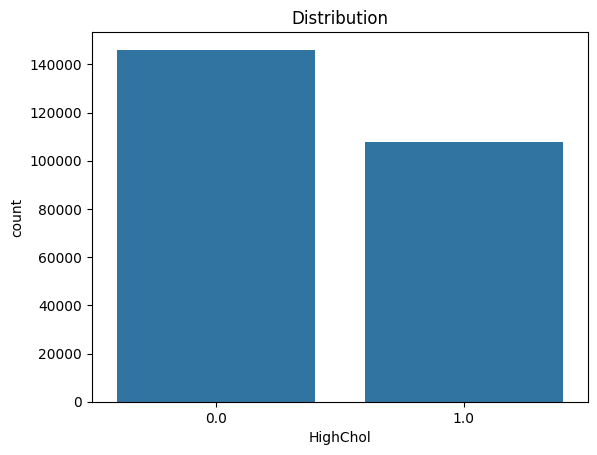

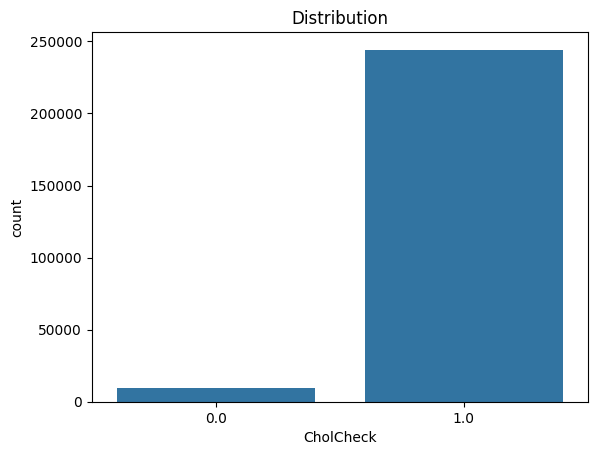

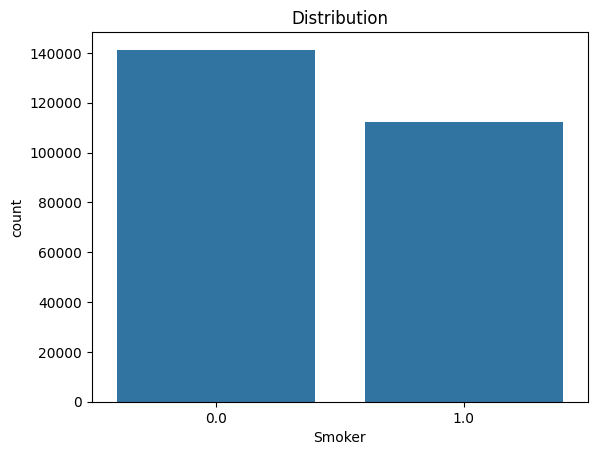

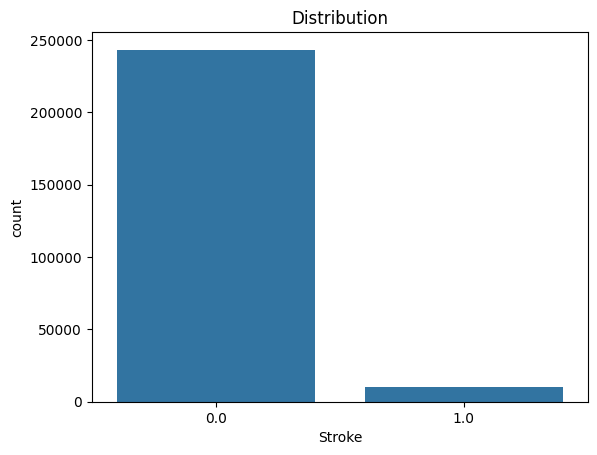

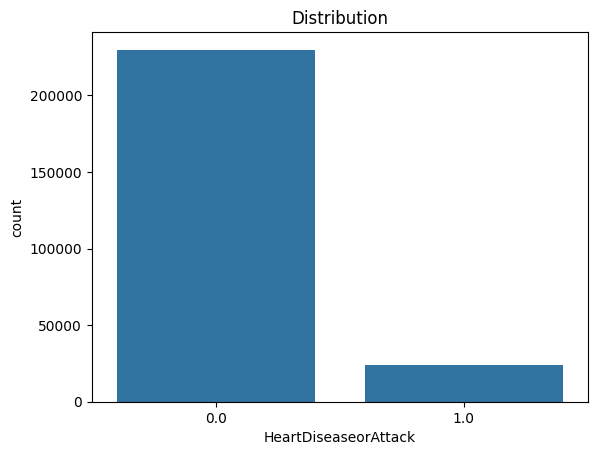

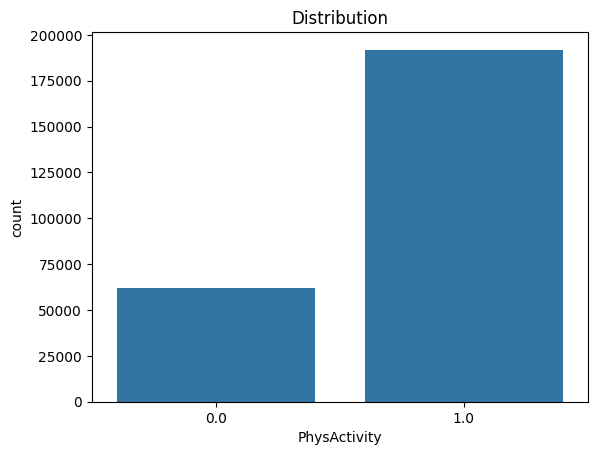

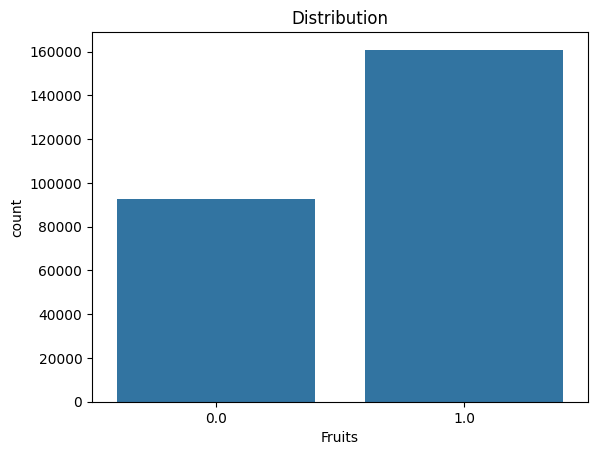

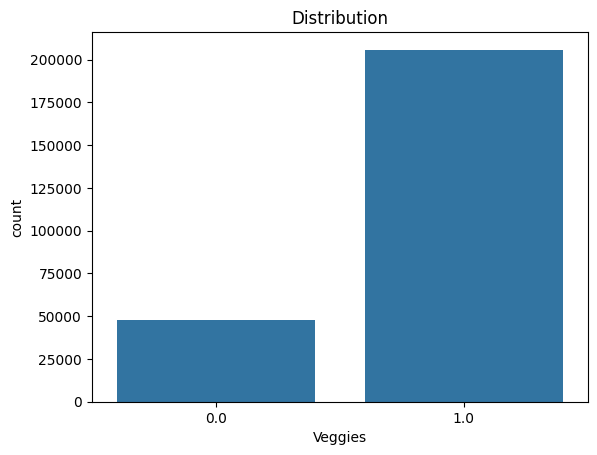

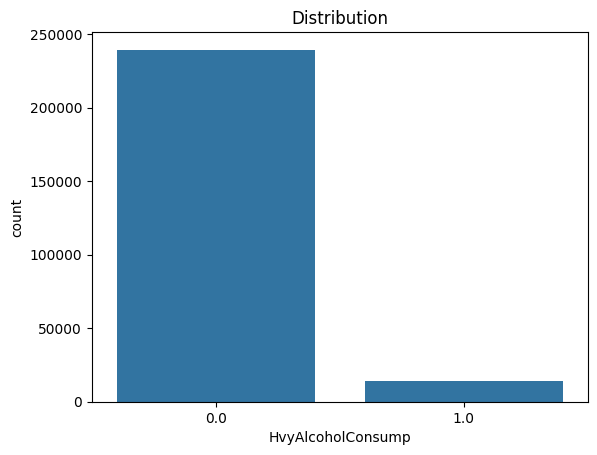

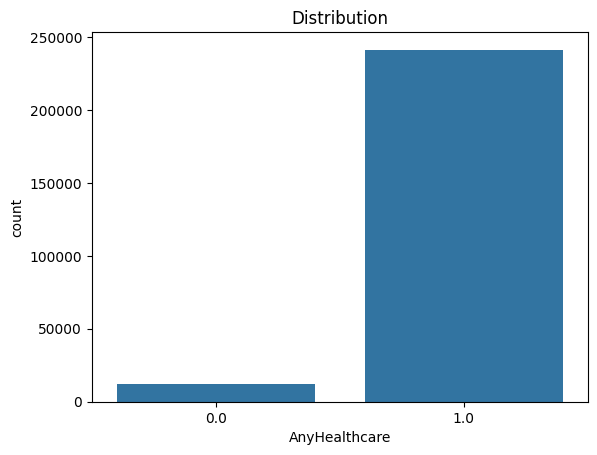

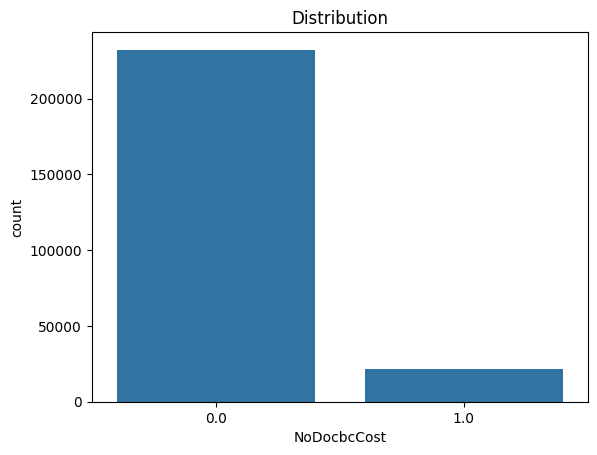

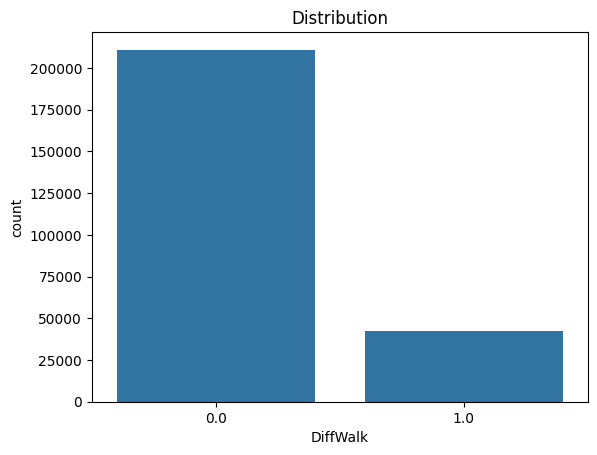

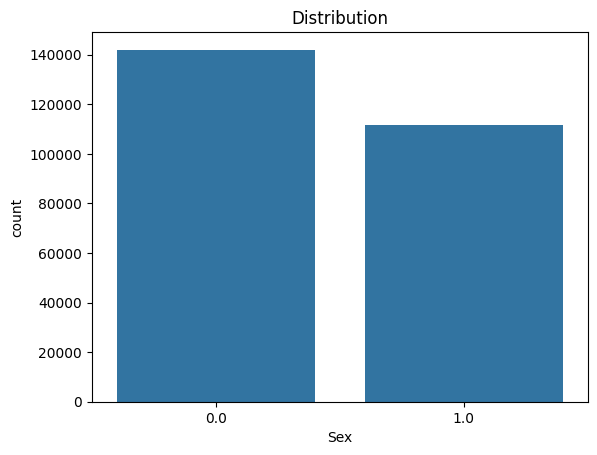

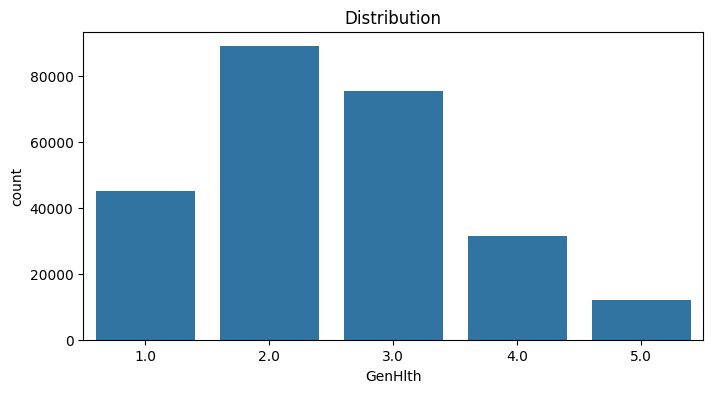

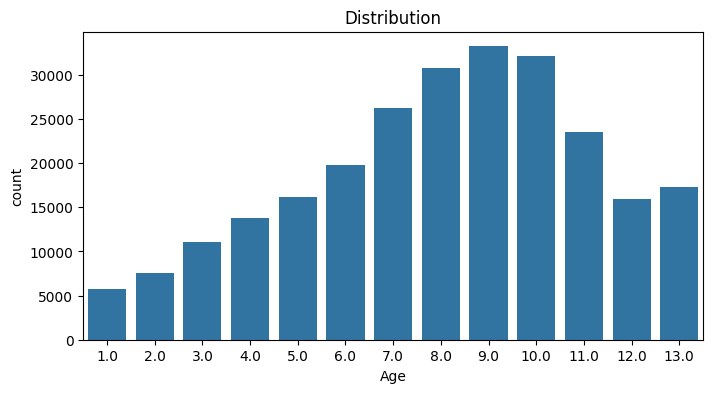

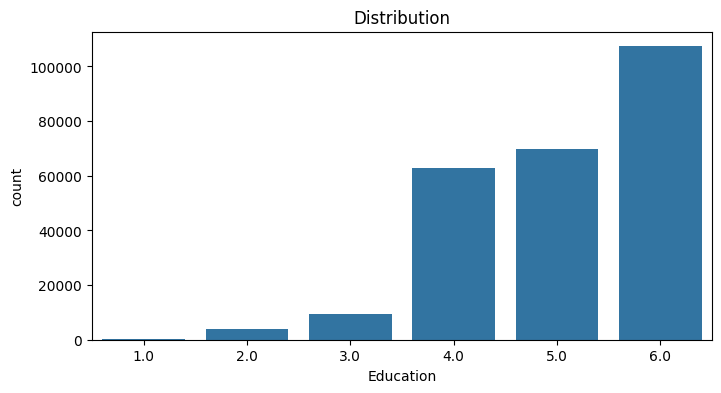

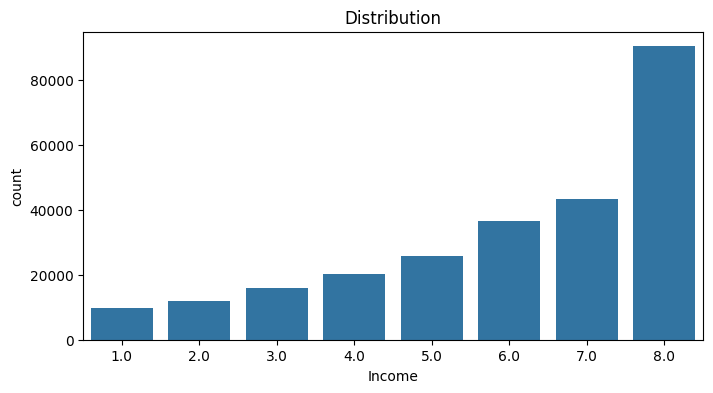

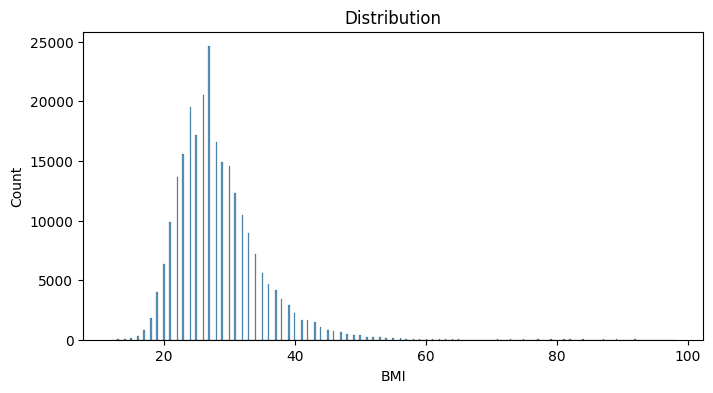

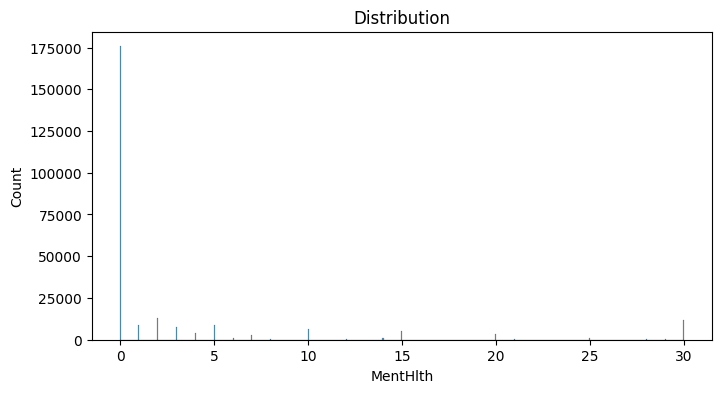

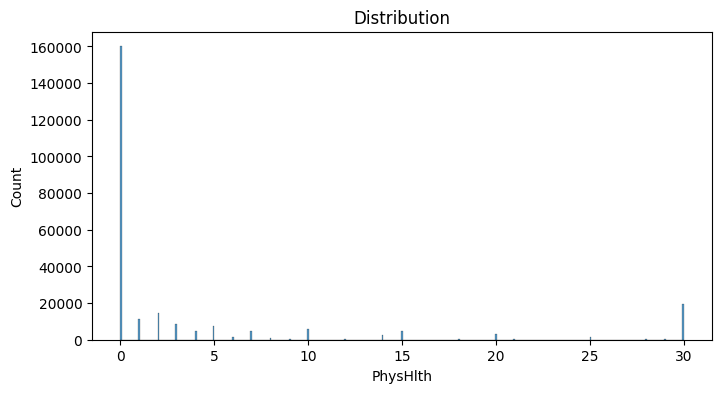

In [14]:
import seaborn as sns

df['Diabetes_012'].value_counts().plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

binary_attributes = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']

for col in binary_attributes:
    sns.countplot(data=df, x=col)
    plt.title('Distribution')
    plt.show()

integer_attributes_bar = ['GenHlth', 'Age', 'Education', 'Income']

integer_attributes_hist = ['BMI', 'MentHlth', 'PhysHlth']

for col in integer_attributes_bar:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col)
    plt.title('Distribution')
    plt.show()

for col in integer_attributes_hist:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=col)
    plt.title('Distribution')
    plt.show()


After plotting I immediately noticed that BMI had some outlier with values > 60 and 70 whith one value at 85 and one at 95. A BMI that high is very unlikely and since this dataset contains 584 individuals with a reported BMI of over 70 it means that something is not right with the data. A BMI above 70 might appear as a few cases in a survey but having 584 rows out of 253 680 (0.23%) seems too high. My suspicion is that while inputing an answer for weight/height an extra 0 was added/removed or a decimal point was changed to the wrong position.

To deal with this I will put a cut off point at BMI 60 as having a BMI above that is extremely uncommon. This will help by removing some of the extreme outliers from the dataset by improving the quality of my data since a majority of these outliers are data errors.

Many educated / wealthier people answered survey

In [15]:
print(df[df['BMI'] > 60].shape)
print(df[df['BMI'] > 70].shape)

# Filter out BMI outliers
df = df[df['BMI'] <= 60]

print(df[df['BMI'] > 60].shape)

df['BMI'].describe()



(805, 22)
(584, 22)
(0, 22)


count    252875.000000
mean         28.230798
std           6.024878
min          12.000000
25%          24.000000
50%          27.000000
75%          31.000000
max          60.000000
Name: BMI, dtype: float64

Before I want to start doing logistic regression I need to check and see if all my features are encoded properly. Since my diabetes classes are imbalanced I also need to address this.

Also renamed some variables because the names were not very clear and readable.

StandardScaler on BMI, MentHlth, PhysHlth, GenHlth?

In [16]:
print(df['Education'].unique())
print(df['Income'].unique())
print(df['Age'].unique())

df = df.rename(columns={
    'Diabetes_012' : 'Diabetes_Status',
    'PhysHlth' : 'Physical_Health_Days',
    'MentHlth' : 'Mental_Health_Days',
    'GenHlth' : 'General_Health',
    'DiffWalk' : 'Difficulty_Walking',
    'NoDocbcCost' : 'No_Doctor_Because_Cost',
    'AnyHealthcare' : 'Any_Healthcare_Access',
    'PhysActivity' : 'Physical_Activity',
    'HeartDiseaseorAttack' : 'Heart_Disease_Attack',
    'CholCheck' : 'Cholesterol_Check',
    'HvyAlcoholConsump' : 'Heavy_Alcohol_Consumption'
})

df.columns




[4. 6. 3. 5. 2. 1.]
[3. 1. 8. 6. 4. 7. 2. 5.]
[ 9.  7. 11. 10.  8. 13.  4.  6.  2. 12.  5.  1.  3.]


Index(['Diabetes_Status', 'HighBP', 'HighChol', 'Cholesterol_Check', 'BMI',
       'Smoker', 'Stroke', 'Heart_Disease_Attack', 'Physical_Activity',
       'Fruits', 'Veggies', 'Heavy_Alcohol_Consumption',
       'Any_Healthcare_Access', 'No_Doctor_Because_Cost', 'General_Health',
       'Mental_Health_Days', 'Physical_Health_Days', 'Difficulty_Walking',
       'Sex', 'Age', 'Education', 'Income'],
      dtype='object')

After fixing and improving the readability of the dataset the next step is to apply StandardScaler() which will be needed for my logistic regression model.

In [18]:
binary_attributes = [
    'HighBP', 'HighChol', 'Cholesterol_Check', 'Smoker', 'Stroke', 'Heart_Disease_Attack',
    'Physical_Activity', 'Fruits', 'Veggies', 'Heavy_Alcohol_Consumption', 'Sex', 'Difficulty_Walking',
    'No_Doctor_Because_Cost', 'Any_Healthcare_Access'
]

numerical_attributes = [
    'BMI', 'Mental_Health_Days', 'Physical_Health_Days', 'Age', 'Education', 'Income', 'General_Health'
]

target_attribute = 'Diabetes_Status'


X = df[binary_attributes + numerical_attributes]
y = df[target_attribute]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42
)

preprocessor = ColumnTransformer(
    transformers=[
        ('binary', 'passthrough', binary_attributes),
        ('numerical', StandardScaler(), numerical_attributes)
    ]
)

logistic_regression_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=2000,
        class_weight='balanced'
    ))
])

logistic_regression_model.fit(X_train, y_train)

y_pred = logistic_regression_model.predict(X_test)
print(classification_report(y_test, y_pred))

c:\Users\emilg\OneDrive\Dokument\GitHub\Caffeine-health-problems-prediction\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

         0.0       0.95      0.67      0.78     63949
         1.0       0.03      0.31      0.05      1322
         2.0       0.36      0.58      0.44     10592

    accuracy                           0.65     75863
   macro avg       0.45      0.52      0.43     75863
weighted avg       0.85      0.65      0.72     75863

